# Support Vector Machines (SVM)

Muestra información de sistema:

In [1]:
from sinfo import sinfo
sinfo()

-----
autopep8    1.5.4
sinfo       0.3.1
-----
IPython             7.19.0
jupyter_client      6.1.7
jupyter_core        4.6.3
notebook            6.1.4
-----
Python 3.8.5 (default, Sep  4 2020, 07:30:14) [GCC 7.3.0]
Linux-5.4.0-48-generic-x86_64-with-glibc2.10
4 logical CPU cores, x86_64
-----
Session information updated at 2021-06-18 12:00


## Preprocesamiento

Importación de librerías y configuración general:

In [2]:
# Librerías para el manejo de datos
import pandas as pd
import numpy as np

# Librerías para gráficas
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Librerías para procesamiento de datos
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Librerías para otras tareas
from sinfo import sinfo

In [3]:
# Configura matplotlib
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configura warnings
import warnings
warnings.filterwarnings('ignore')

Lectura y preprocesamiento de los datos:

In [4]:
# Lee el dataset
df = pd.read_csv('ESL.mixture.csv')
df.head(3)

,X1,X2,y
0,2.526093,0.321050,0
1,0.366954,0.031462,0
2,0.768219,0.717486,0


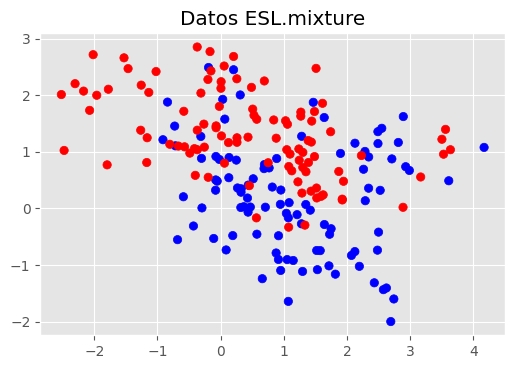

In [5]:
# Visualiza distribución de los datos.
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df.X1, df.X2, c=df.y);
ax.set_title("Datos ESL.mixture");

Divide el dataset en conjuntos de entrenamiento y de prueba:

In [6]:
X = df.drop(columns = 'y')
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.reshape(-1,1),
    train_size = 0.8,
    random_state = 1234,
    shuffle = True
)

## SVM Lineal

Genera el modelo:

In [7]:
modelo = SVC(C = 100, kernel = 'linear', random_state=1234)
modelo.fit(X_train, y_train)

SVC(C=100, kernel='linear', random_state=1234)

Muestra representación gráfica de los límites de clasificación:

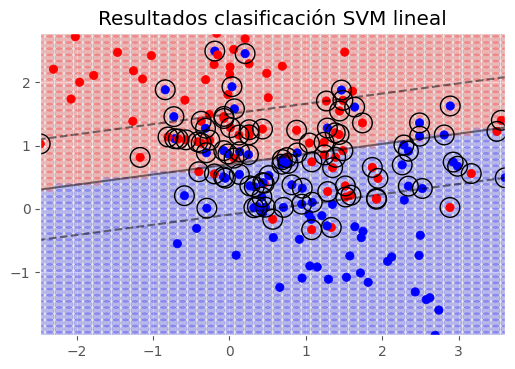

In [8]:
# Grid de valores.
x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
y = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Predicción valores grid.
pred_grid = modelo.predict(grid)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(grid[:,0], grid[:,1], c=pred_grid, alpha = 0.2)
ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

# Vectores soporte.
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=200, linewidth=1,
    facecolors='none', edgecolors='black'
)

# Hiperplano de separación.
ax.contour(
    X,
    Y,
    modelo.decision_function(grid).reshape(X.shape),
    colors = 'k',
    levels = [-1, 0, 1],
    alpha  = 0.5,
    linestyles = ['--', '-', '--']
)

ax.set_title("Resultados clasificación SVM lineal");

Muestra representación gráfica de los límites de clasificación utilizando mlxtend:

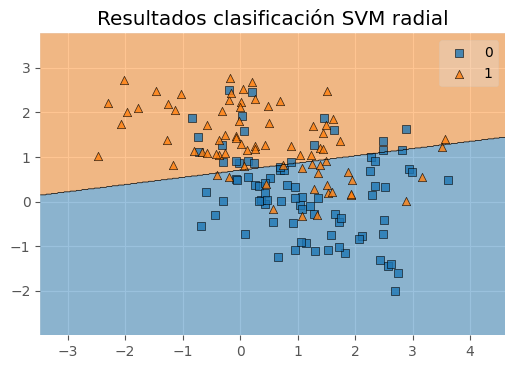

In [9]:
fig, ax = plt.subplots(figsize=(6,4))

plot_decision_regions(
    X = X_train.to_numpy(),
    y = y_train.flatten(),
    clf = modelo,
    ax = ax
)

ax.set_title("Resultados clasificación SVM radial");

Muestra la accuracy de las predicciones:

In [10]:
predicciones = modelo.predict(X_test)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 70.0%


## SVM Radial

A continuación se implementa la SVM con un kernel radial, y se usa la validación cruzada para identifica el valor óptimo de penalización $C$:

In [11]:
# Grid de hiperparámetros
param_grid = {'C': np.logspace(-5, 7, 20)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
    estimator  = SVC(kernel= "rbf", gamma='scale'),
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 3, 
    verbose = 0,
    return_train_score = True
)

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados de la grid
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
8,1.12884,0.762520,0.023223,0.790778,0.035372
12,379.269,0.750641,0.076068,0.868777,0.007168
7,0.263665,0.750175,0.030408,0.778228,0.026049
9,4.83293,0.744118,0.044428,0.815729,0.026199
11,88.5867,0.738062,0.064044,0.859431,0.019840


Muestra los mejores hiperparámetros por validación cruzada:

In [12]:
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
modelo = grid.best_estimator_

{'C': 1.1288378916846884} : 0.7625203820172374 accuracy


Muestra representación gráfica de los límites de clasificación:

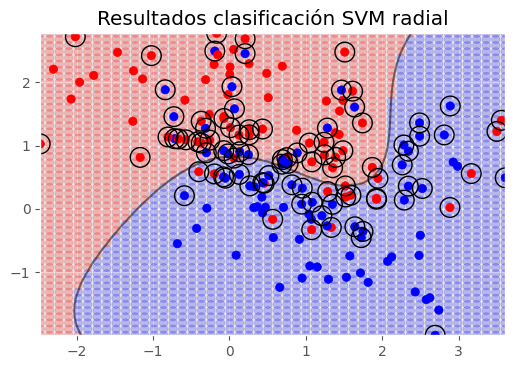

In [13]:
# Grid de valores
x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
y = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Predicción valores grid
pred_grid = modelo.predict(grid)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(grid[:,0], grid[:,1], c=pred_grid, alpha = 0.2)
ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

# Vectores soporte
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=200, linewidth=1,
    facecolors='none', edgecolors='black'
)

# Hiperplano de separación
ax.contour(
    X,
    Y,
    modelo.decision_function(grid).reshape(X.shape),
    colors='k',
    levels=[0],
    alpha=0.5,
    linestyles='-'
)

ax.set_title("Resultados clasificación SVM radial");

Muestra representación gráfica de los límites de clasificación utilizando mlxtend:

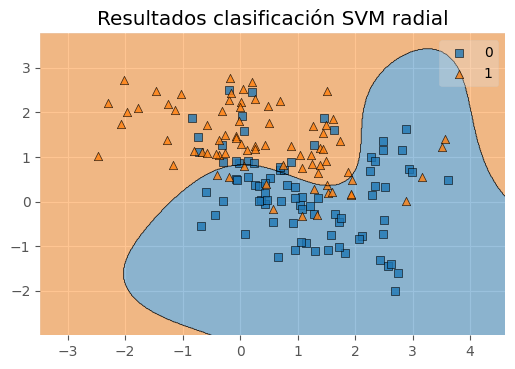

In [14]:
fig, ax = plt.subplots(figsize=(6,4))

plot_decision_regions(
    X = X_train.to_numpy(),
    y = y_train.flatten(),
    clf = modelo,
    ax = ax
)

ax.set_title("Resultados clasificación SVM radial");

Muestra la accuracy de las predicciones:

In [15]:
predicciones = modelo.predict(X_test)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 80.0%


Genera matriz de confusión de las predicciones de prueba:

In [16]:
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predicciones,
    rownames=['Real'],
    colnames=['Predicción']
)

confusion_matrix

Predicción,0,1
Real,,
0,14,3
1,5,18


https://www.cienciadedatos.net/documentos/py24-svm-python.html